# 인물 사진 모드 구현하기

how? 

1. 배경 - 인물 분리 : semantic segmentation(pre-trained DeepLab V3)
2. 마스킹된 배경에 blur 처리
3. blurred background와 인물 사진 합치기

## 1. 이미지 불러오기

In [1]:
#load module
import cv2
import numpy as np
import os
import tarfile
import urllib #url 처리

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'
file_list = os.listdir(dir_path)
file_num = len(file_list)

In [3]:
#load images 
def load_img():
    
    img_dict = {}
    for file in file_list:
        img_path = os.path.join(dir_path,file)
        img = cv2.imread(img_path)
        
        img_dict[file] = img
    
    return img_dict

In [4]:
#show images
def show_img(img_dict,row,col):
    
    fig, ax = plt.subplots(row,col,figsize = (20,20))
    img_name_list = list(img_dict.keys())
    
    print(img_name_list)
    
    for i in range(col*row):
        
        img_name = img_name_list[i]
        img_rgb = cv2.cvtColor(img_dict[img_name],cv2.COLOR_BGR2RGB)
        
        ax[i].imshow(img_rgb)
        ax[i].set_title(img_name)
        
    plt.show()

['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg']


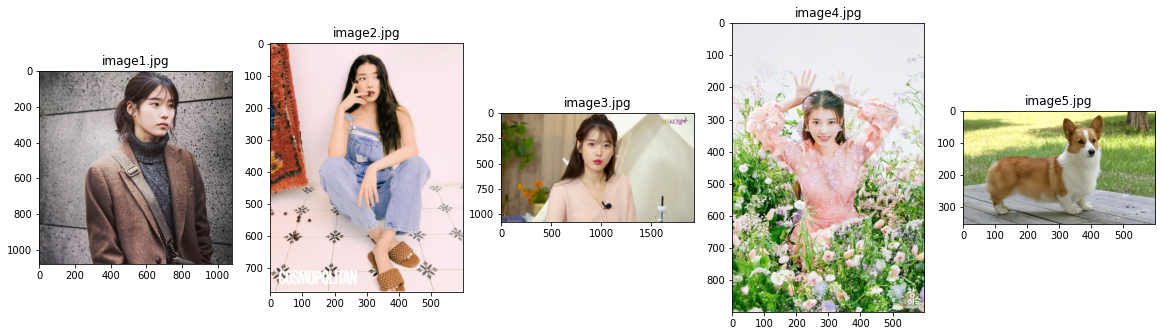

In [5]:
#show image
image_dict = load_img()
image_dict = dict(sorted(image_dict.items()))
show_img(image_dict,1,file_num)

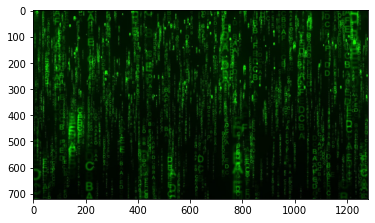

In [6]:
chrom_path = os.getenv('HOME')+'/aiffel/human_segmentation/chroma_key.jpg'
chrom_key = cv2.imread(chrom_path)
plt.imshow(chrom_key)

## 2. DeepLab 사용하기

#### 모델 선언

In [7]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### pre-trained 데이터 다운로드

In [8]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


#### Label? PASCAL VOC 기반

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

LABEL_NAMES = {i : LABEL_NAMES[i] for i in range(len(LABEL_NAMES))}
LABEL_NAMES

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv'}

## 3. 인물 사진 만들기

In [10]:
#portrait_mode
def portrait_model(img_name,img_orig,label):
    
    img_resized , seg_map = MODEL.run(img_orig)
    
    obj = np.unique(seg_map)
    obj_num = len(obj)
    print(img_name,"Detected :",", ".join([LABEL_NAMES[i] for i in obj]))
    
    
    img_seg_dict = {}
    
    #image segmentation
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출 ==> LABEL_NAMES 참고 seg_map == 15인 것만 남겨두고 나머지는 배경 처리
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8) #img_mask
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    #mask resizing
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    #image_blur
    img_orig_blur = cv2.blur(img_orig, (21,21))
    
    #background
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    #
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) #img_mask_color ==255면 img_orig else img_bg_blur
    
    img_seg_dict['segmentation'] = img_show
    img_seg_dict['mask'] = img_mask_up
    img_seg_dict['result'] = img_concat
    
    return img_seg_dict
    

In [24]:
#chroma_key
def chroma_key(img_name,img_orig,label,c_key):
    img_resized , seg_map = MODEL.run(img_orig)
    
    obj = np.unique(seg_map)
    obj_num = len(obj)
    print(img_name,"Detected :",", ".join([LABEL_NAMES[i] for i in obj]))
    
    
    img_seg_dict = {}
    
    #image segmentation
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 사람만 추출 ==> LABEL_NAMES 참고 seg_map == 15인 것만 남겨두고 나머지는 배경 처리
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8) #img_mask
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    
    #mask resizing
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    #chrome resizing  
    c_key_resized = cv2.resize(c_key,img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    
    #background
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    #img_bg_mask = cv2.bitwise_not(img_mask_color)
    #img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    #chroma_key
    img_concat = np.where(img_mask_color==255, img_orig, c_key_resized) #img_mask_color ==255면 img_orig else img_bg_blur
    
    img_seg_dict['segmentation'] = img_show
    img_seg_dict['mask'] = img_mask_up
    img_seg_dict['result'] = img_concat
    
    return img_seg_dict
    

#### 인물 모드 실행

In [12]:
image1 = portrait_model('image1',image_dict['image1.jpg'],15)
image2 = portrait_model('image2',image_dict['image2.jpg'],15)
image3 = portrait_model('image3',image_dict['image3.jpg'],15)
image4 = portrait_model('image4',image_dict['image4.jpg'],15)
image5 = portrait_model('image5',image_dict['image5.jpg'],12)

image1 Detected : background, person
image2 Detected : background, person
image3 Detected : background, person, pottedplant
image4 Detected : background, person, pottedplant
image5 Detected : background, dog


####  결과 확인

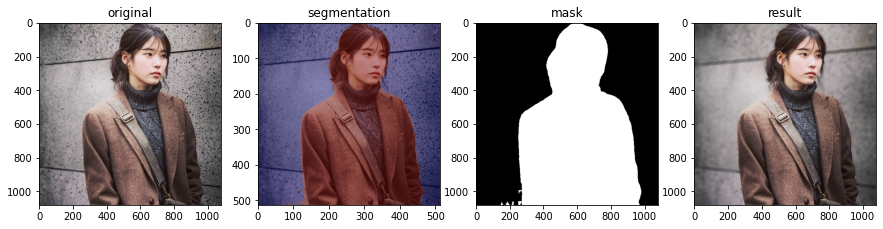

In [13]:
#image1
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image1.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image1['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image1['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image1['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

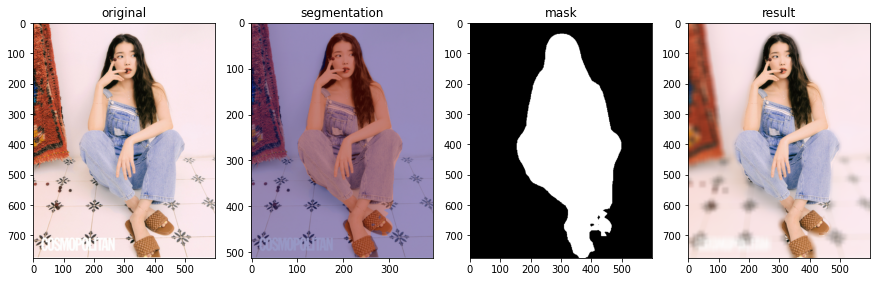

In [14]:
#image2
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image2.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image2['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image2['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image2['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

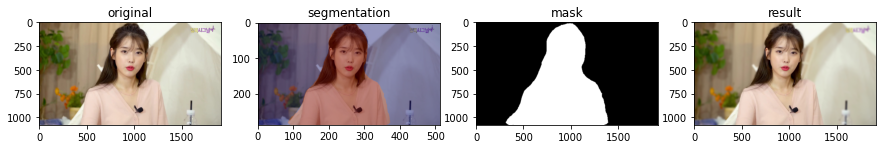

In [15]:
#image3
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image3.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image3['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image3['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image3['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

#### image4에서 배경 분리가 잘 안됐다.

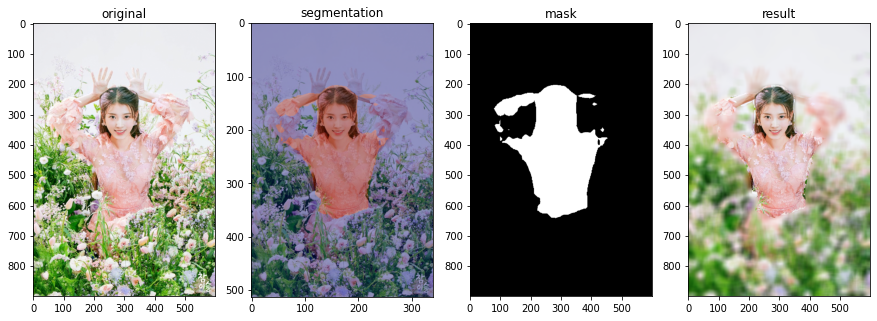

In [16]:
#image4
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image4.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image4['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image4['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image4['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

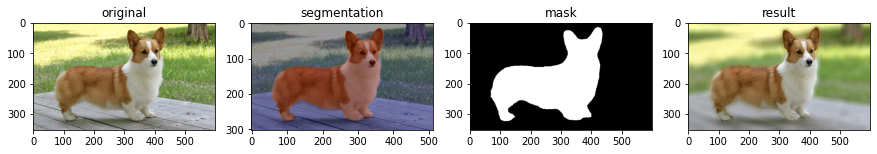

In [17]:
#image5
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image5.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image5['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image5['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image5['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

#### 크로마키 모드 실행

In [25]:
image1_c = chroma_key('image1',image_dict['image1.jpg'],15,chrom_key)
image2_c = chroma_key('image2',image_dict['image2.jpg'],15,chrom_key)
image3_c = chroma_key('image3',image_dict['image3.jpg'],15,chrom_key)
image4_c = chroma_key('image4',image_dict['image4.jpg'],15,chrom_key)
image5_c = chroma_key('image5',image_dict['image5.jpg'],12,chrom_key)

image1 Detected : background, person
image2 Detected : background, person
image3 Detected : background, person, pottedplant
image4 Detected : background, person, pottedplant
image5 Detected : background, dog


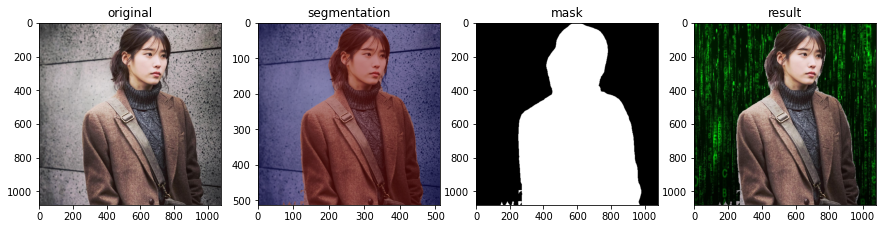

In [27]:
#image1_c
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image1.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image1_c['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image1_c['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image1_c['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

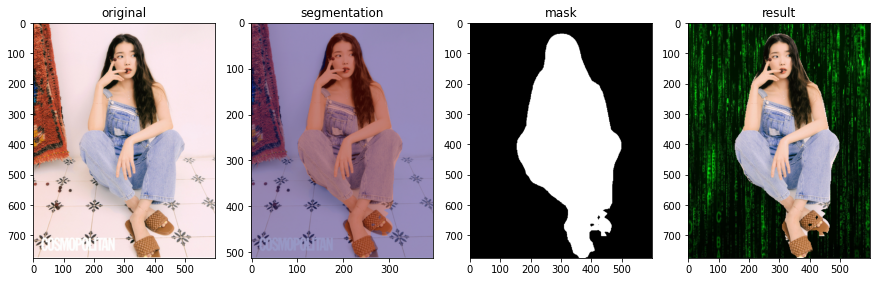

In [28]:
#image2_c
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image2.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image2_c['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image2_c['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image2_c['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

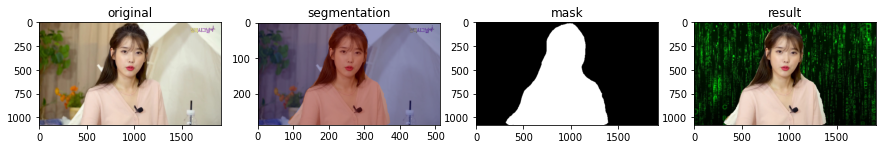

In [30]:
#image3_c
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image3.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image3_c['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image3_c['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image3_c['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

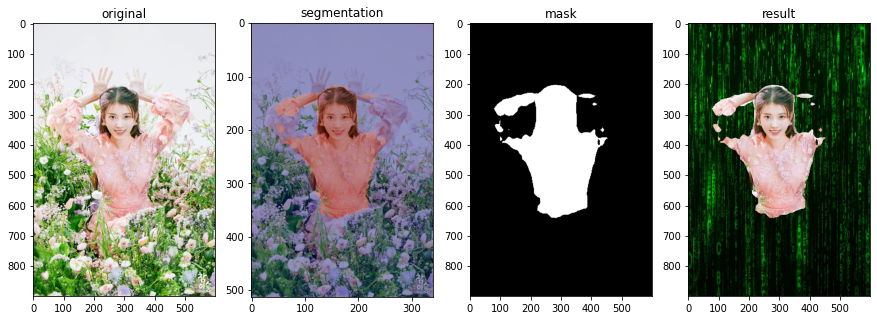

In [31]:
#image4_c
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image4.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image4_c['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image4_c['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image4_c['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

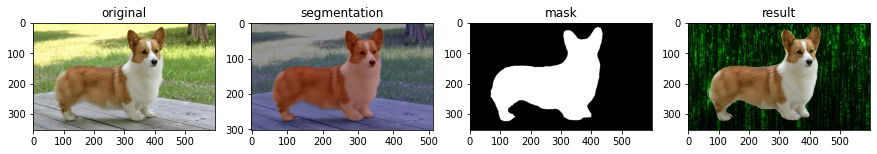

In [32]:
#image5_c
fig, ax = plt.subplots(1,4,figsize=(15,15))

ax[0].imshow(cv2.cvtColor(image_dict['image5.jpg'], cv2.COLOR_BGR2RGB))
ax[0].set_title('original')

ax[1].imshow(cv2.cvtColor(image5_c['segmentation'], cv2.COLOR_BGR2RGB))
ax[1].set_title('segmentation')

ax[2].imshow(image5_c['mask'],cmap=plt.cm.binary_r)
ax[2].set_title('mask')

ax[3].imshow(cv2.cvtColor(image5_c['result'], cv2.COLOR_BGR2RGB))
ax[3].set_title('result')

plt.show()

## 4. 문제점 개선하기

In [ ]:
fig = plt.figure(figsize=(15,15))  
plt.axis('off')
plt.imshow(cv2.cvtColor(image4['result'], cv2.COLOR_BGR2RGB))

배경의 꽃 때문에 segmentation이 잘 되지 않아서 인물로 인식되지 않은 부분에 blur가 되는 현상 발생

![image](https://user-images.githubusercontent.com/86637320/129400992-63a6d426-d0ed-4571-962e-4a271d866008.png)

어떻게 해결?   

- 심도를 정확하게 얻어낸 다음 **심도**를 기준으로 masking 영역을 정하면 좀 더 나은 결과를 얻을 수 있을 것이다.
- 이때 pre-trained 결과가 주어지는 depth estimation model을 선택해 프로젝트에 사용한다.   
따라서 [Monodepth2](https://github.com/nianticlabs/monodepth2), [MegaDepth](https://github.com/zl548/MegaDepth)과 같은 모델을 사용할 수 있을 것이다.

사진 처럼 동일 instance의 경우 비슷한 depth를 가짐을 확인할 수 있다.

![image](https://repository-images.githubusercontent.com/184593965/1d3e0500-6cf2-11e9-8a90-7fbed404dc88)

# 정리

- 인물 사진 모드를 semantic segmentation을 이용해서 구현했다.

노드 진행 전엔 카메라에 대해서 하나도 몰랐었다. 하지만 segmentation이 잘 되지 않는 문제점을 해결하기 위해서    
카메라에 대해서 많이 찾아보면서 어느 정도 개념이 생겨서 문제를 해결할 수 있는 나름의 방안도 생각해보았다.

앞서 언급했던 [Monodepth2](https://github.com/nianticlabs/monodepth2), [MegaDepth](https://github.com/zl548/MegaDepth)를 이용해서 새로운 mask 영역을 얻어 segmentation 문제를 해결하려고 한다. 

- 반복되는 작업들을 최대한 함수로 묶어서 코드를 구성했다.

지금 생각해보니 portrait_model, chroma_key 함수에서 for 문으로 segmentation 과정을 묶어서 Nested dict로 표현했으면 더 깔끔했을 거 같다.